# An example of using candex with rotated Latitude and Longitude (every grid has it own lat and lon)
## Remapping of CONUS WRF to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [4]:
from candex import candex

cndx = candex() # initialize candex object
cndx.name_of_case             = 'WRF_Medicine_Hat'
cndx.temporary_candex_folder  = '../temporary/' # temporary path that the candex generated GIS files and rempped file will be saved
cndx.name_of_target_shp       = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
cndx.name_of_nc_files         = '../data/Source_nc_WRF/WRF*.nc'
cndx.name_of_var_name         = ['T2']
cndx.name_of_var_lon          = 'XLONG'
cndx.name_of_var_lat          = 'XLAT'
cndx.name_of_var_time         = 'time'
cndx.name_of_nc_output_folder = '../output/'
cndx.format_list              = ['f4']
cndx.fill_value_list          = ['-9999.00']
#cndx.name_of_remap_file        = '../temporary/WRF_Medicine_Hat_remapping.csv' # if uncommneted candex will use this and skip GIS taskes

# execute candex
cndx.run_candex()


no  author name is provide and the author name is changes to (author name)!
remap file is provided; candex will use this file and skip calculation of remapping
candex case exists in the remap file
candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['time', 'y', 'x']
candex detects that the longitude varibales has dimensions of:
['y', 'x']
candex detects that the latitude varibales has dimensions of:
['y', 'x']
Remapping ../data/Source_nc_WRF/WRF_merged_2000-10-01.nc to ../output/WRF_Medicine_Hat_remapped_2000-10-01-00-00-00.nc
Started at date and time 2021-02-17 11:00:07.009011
Ended   at date and time 2021-02-17 11:00:07.145349


--------------
--------------
# Visualization of the source and the results

<xarray.Dataset>
Dimensions:      (time: 24, x: 199, y: 168)
Coordinates:
  * time         (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
    XLONG        (y, x) float64 ...
    XLAT         (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    I_RAINNC     (time, y, x) float64 ...
    LWDNB        (time, y, x) float32 ...
    P            (time, y, x) float32 ...
    PREC_ACC_C   (time, y, x) float32 ...
    PREC_ACC_NC  (time, y, x) float32 ...
    Q2           (time, y, x) float32 ...
    RAINC        (time, y, x) float32 ...
    RAINNC       (time, y, x) float32 ...
    SWDNB        (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
(33432,)


(48.5, 51.8)

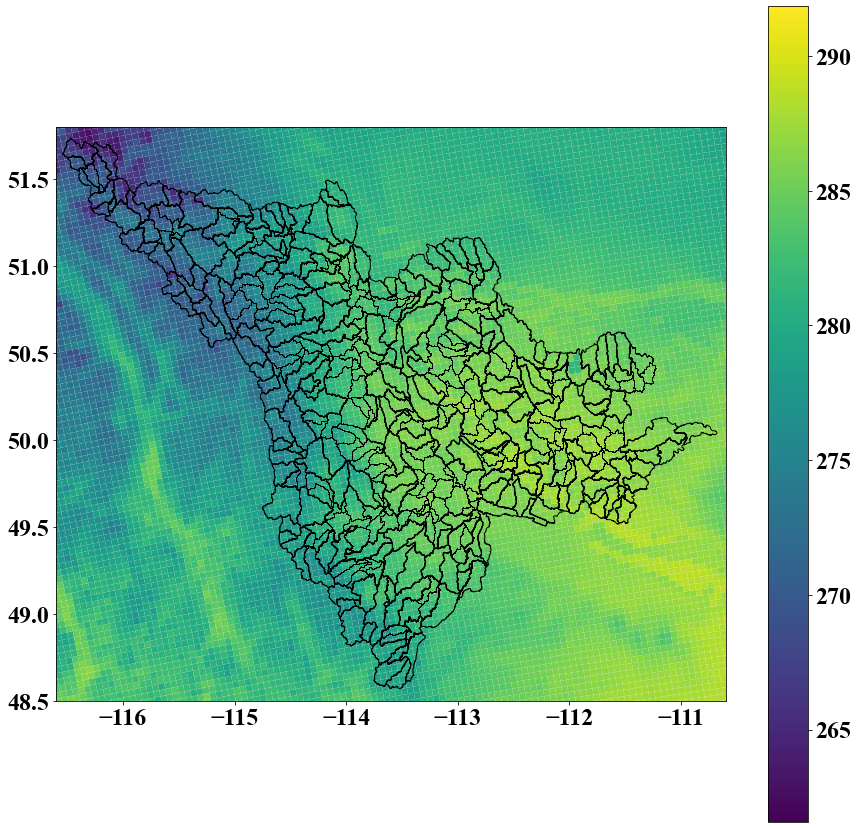

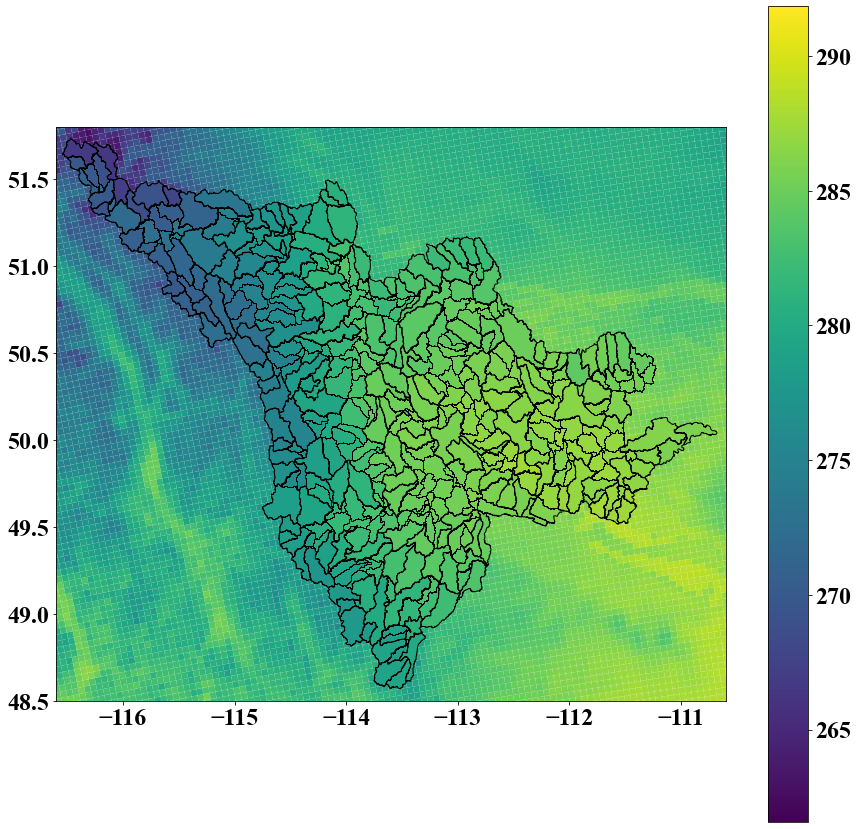

In [5]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)



# visualize the original netCDF for the first file, first time step
shp_source = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case + '_source_shapefile.shp') # load the target shapefile
# load the infromation on the
nc_names = sorted(glob.glob (cndx.name_of_nc_files))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
print(ds)
T2       = np.array(ds.T2 [3,:,:]).flatten() # the first time frame of the first 
print(T2.shape)
lat      = np.array(ds.XLAT).flatten()  # the first time frame of the first 
lon      = np.array(ds.XLONG).flatten()  # the first time frame of the first 

lat_shp = shp_source ['lat_s']
lon_shp = shp_source ['lon_s']
idx = np.zeros(len(lat_shp))
value = np.zeros(len(lat_shp))

for i in np.arange(len(lat_shp)):
    # find the row of the shapefile that is closes to the point
    diff = abs(lat-lat_shp[i])+ abs(lon-lon_shp[i])
    temp = np.where(diff == np.min(diff))
    idx[i] = temp[0].astype(int)
    a = idx[i]
    value[i] = T2 [a.astype(int)]


shp_source ['value'] = value


f, axes = plt.subplots(1,1,figsize=(15,15))
shp_source.plot(column='value', ax = axes, legend=True)
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])

shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case + '_target_shapefile.shp') # load the target shapefile
shp_target.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, ax = axes)




#

# visualize the remapped netCDF for the first file, first time step
# target nc file
nc_names = sorted(glob.glob (cndx.name_of_nc_output_folder + cndx.name_of_case + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
values   = ds.T2 [3,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by candex (with consistent IDs)
shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case + '_target_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd


# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
shp_source.plot(column='value', ax = axes, legend=True)
shp_target.plot(column= 'value', edgecolor='k',linewidth = 1, ax = axes , vmin = np.min(T2), vmax = np.max(T2))#, legend=True)
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])


